# Confusion matrix

Part of a [Recidivism Case Study](https://github.com/AllenDowney/RecidivismCaseStudy)

by [Allen Downey](https://allendowney.com)

[MIT License](https://opensource.org/licenses/MIT)

## Review

An ideal test should have equal *predictive value* in all groups; that is, two people with the same risk score should have the same probability of recidivism, regardless of what group they are in.

An ideal test should also have the same *error rates* for all groups; that is, any two recidivists should have same probability of being mis-classified as low risk (FNR), and any two non-recidivists should have the same probability of being mis-classified as high risk (FPR).


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Data

The authors of "Machine Bias" published their data and analysis in [this repository](https://github.com/propublica/compas-analysis).

The terms of use for the data [are here](https://www.propublica.org/datastore/terms).  In compliance with those terms, I am not redistributing the data.

The following cell downloads the data file we'll use directly from their repository.

In [2]:
import os

if not os.path.exists('compas-scores-two-years.csv'):
    !wget https://github.com/propublica/compas-analysis/raw/master/compas-scores-two-years.csv

The following cell reads the data file:

In [3]:
cp = pd.read_csv("compas-scores-two-years.csv")
cp.shape

(7214, 53)

The dataset includes 7214 rows, one for each defendant, and 53 columns.

## Data bias

[**Note:** I wrote about data bias in the previous notebook, but I am repeating it here in case someone reads this notebook without reading the previous one.]

Systems like COMPAS are trying to predict whether a defendant will *commit* another crime if released.  But the dataset reports whether a defendant was *charged* with another crime.

Not everyone who commits a crime gets charged (not even close).  The probability of getting charged for a particular crime depends on the type of crime and location, the presence of witnesses and their willingness to work with police, the decisions of police about where to patrol, what crimes to investigate, and who to arrest, and decisions of prosecutors about who to charge.

It is likely that every one of these factors depends on the race of the defendant.  In this dataset, the prevalence of *new charges* is higher for black defendants, but that doesn't necessarily mean that the prevalence of *new crimes* is higher.  

If the dataset is affected by racial bias in the probability of being charged, prediction algorithms like COMPAS will be biased, too.  In discussions of whether and how these systems should be used in the criminal justice system, this is an important issue.  

However, I am going to put it aside *for now* in order to focus on understanding the arguments posed in the ProPublica article and the metrics they are based on.  For the rest of this notebook I will take the "recidivism rates" in the dataset at face value; but I will try to be clear about that they mean (and don't mean).

## Code

The functions from the previous notebook are in a file called `utils.py`; the following cell downloads it if you don't already have it:

In [4]:
import os

if not os.path.exists('utils.py'):
    !wget https://github.com/AllenDowney/RecidivismCaseStudy/utils.py

## Recreating the confusion matrix

To see why, consider this: the confusion matrix has four numbers in it, but they have to add up to 100%, so if you give me any three elements of the matrix, I can compute the fourth.

In the same way, if you provide any three (independent) metrics, I can compute the elements of the matrix and any other metrics.  Specifically:

* Given prevalence, PPV and NPV, we can compute the confusion matrix and the error rates.

* Given prevalence, FPR and FNR, we can compute the confusion matrix and the predictive values.

We could do the algebra by hand, but it is easier (and probably more reliable) to use SymPy.

Here are the symbols we'll use:

In [5]:
from sympy import symbols, Eq, solve

tn, fp, fn, tp = symbols('tn, fp, fn, tp')
ppv, npv, prev = symbols('ppv, npv, prev')
fpr, fnr = symbols('fpr, fnr')

And here are the equations that relate the metrics to the elements of the confusion matrix.

In [6]:
eq1 = Eq(prev, tp+fn)
eq1

Eq(prev, fn + tp)

In [7]:
eq2 = Eq(fpr, fp / (fp+tn))
eq2

Eq(fpr, fp/(fp + tn))

In [8]:
eq3 = Eq(fnr, fn / (fn+tp))
eq3

Eq(fnr, fn/(fn + tp))

In [9]:
eq4 = Eq(ppv, tp / (tp+fp))
eq4

Eq(ppv, tp/(fp + tp))

In [10]:
eq5 = Eq(npv, tn / (tn+fn))
eq5

Eq(npv, tn/(fn + tn))

In [11]:
eq6 = Eq(tn+fp+fn+tp, 1)
eq6

Eq(fn + fp + tn + tp, 1)

We can use `solve` to get expressions for the elements of the confusion matrix in terms of `ppv`, `npv`, and `prev`:

In [12]:
soln1 = solve([eq1, eq2, eq3, eq4, eq5, eq6], 
              [tp, fp, fn, tn, fpr, fnr])
soln1[0]

(ppv*(npv + prev - 1)/(npv + ppv - 1),
 -(ppv - 1)*(npv + prev - 1)/(npv + ppv - 1),
 -(npv - 1)*(ppv - prev)/(npv + ppv - 1),
 npv*(ppv - prev)/(npv + ppv - 1),
 (ppv - 1)*(npv + prev - 1)/((prev - 1)*(npv + ppv - 1)),
 -(npv - 1)*(ppv - prev)/(prev*(npv + ppv - 1)))

We can also solve for the elements of the confusion matrix in terms of `fpr`, `fnr`, and `prev`:

In [13]:
soln2 = solve([eq1, eq2, eq3, eq4, eq5, eq6], 
              [tp, fp, fn, tn, ppv, npv])

soln2[0]

(prev*(1 - fnr),
 fpr*(1 - prev),
 fnr*prev,
 (fpr - 1)*(prev - 1),
 prev*(fnr - 1)/(fnr*prev + fpr*prev - fpr - prev),
 (fpr - 1)*(prev - 1)/(fnr*prev + fpr*prev - fpr - prev + 1))

The following function takes `ppv`, `npv`, and `prev` and uses the expressions from `soln1` to compute a confusion matrix with those metrics.

In [14]:
def constant_predictive_value(ppv, npv, prev):
    """Make a confusion matrix with given metrics.
    
    ppv: positive predictive value (0-100)
    npv: negative predictive value (0-100)
    prev: prevalence (0-100)
    
    returns: confusion matrix
    """
    ppv /= 100
    npv /= 100
    prev /= 100
    a = np.array((ppv*(npv + prev - 1)/(npv + ppv - 1),
                -(ppv - 1)*(npv + prev - 1)/(npv + ppv - 1),
                -(npv - 1)*(ppv - prev)/(npv + ppv - 1),
                npv*(ppv - prev)/(npv + ppv - 1)))
    
    return pd.DataFrame(a.reshape((2, 2)))

To test it, I'll use metrics from the confusion matrix for all defendants.

In [17]:
from utils import make_matrix
from utils import compute_metrics

matrix_all = make_matrix(cp)
metrics_all = compute_metrics(matrix_all, 'All defendants')
metrics_all

,Percent
All defendants,
FPR,32.349230
FNR,37.403876
PPV,61.350618
NPV,68.796510
Prevalence,45.065151


I'll extract PPV, NPV, and prevalence.

In [19]:
from utils import predictive_value
from utils import prevalence

ppv, npv = predictive_value(matrix_all)
prev = prevalence(matrix_all)

Given those values, we can reconstruct the confusion matrix and compute the metrics again.

In [20]:
matrix = constant_predictive_value(ppv, npv, prev)
metrics_pred = compute_metrics(matrix)
metrics_pred

,Percent
,
FPR,32.349230
FNR,37.403876
PPV,61.350618
NPV,68.796510
Prevalence,45.065151


These "predicted metrics" are the same as the actual metrics, except for small errors due to floating-point approximation.

In [21]:
metrics_pred - metrics_all

,Percent
,
FPR,0.000000e+00
FNR,0.000000e+00
PPV,0.000000e+00
NPV,-1.421085e-14
Prevalence,0.000000e+00


So that confirms that we can use PPV, NPV and prevalence to compute FPR and FNR.

Now let's see what happens if we hold PPV and NPV constant, and vary prevalence. 

## The constant predictive value model

To show these effects more clearly, I'll sweep through a range of prevalences and plot the error rates we get if we hold predictive values constant.

In [30]:
from utils import error_rates

def run_cpv_model(cp):
    """Run the constant predictive value model.

    cp: DataFrame of COMPAS data

    returns: DataFrame with a row for each prevalence and
             a column for each metric (FPR, FNR)
    """
    matrix_all = make_matrix(cp)

    ppv, npv = predictive_value(matrix_all)
    prevalences = np.linspace(35, 55, 11)

    pred_er = pd.DataFrame(columns=['fpr', 'fnr'])

    for prev in prevalences:
        m = constant_predictive_value(ppv, npv, prev)
        pred_er.loc[prev] = error_rates(m)

    return pred_er

In [31]:
pred_er = run_cpv_model(cp)
pred_er

,fpr,fnr
35.0,7.488034,77.925569
37.0,11.795671,68.118564
39.0,16.385776,59.317406
41.0,21.287075,51.374897
43.0,26.532324,44.171227
45.0,32.159046,37.607882
47.0,38.210427,31.603121
49.0,44.736425,26.088543
51.0,51.795158,21.006482
53.0,59.454634,16.307973


The following figure shows the error rates we would expect from a test with equal predictive value for all groups, regardless of prevalence.

In [34]:
from utils import decorate

def plot_cpv_model(pred_er):
    """Plot error rates with constant predictive values.
    
    pred_er: DataFrame of predicted error rates
    """
    pred_er['fpr'].plot(label='Predicted FPR', color='C2')
    pred_er['fnr'].plot(label='Predicted FNR', color='C4')
    decorate(xlabel='Prevalence', ylabel='Percent',
             title='Error rates, constant predictive value')

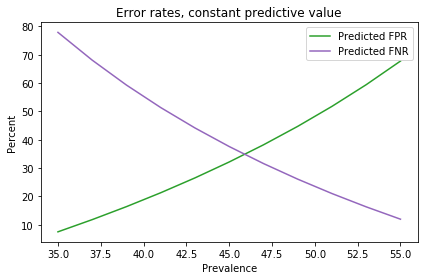

In [35]:
plot_cpv_model(pred_er)
plt.legend();

As prevalence increases, FPR increases and FNR decreases.  Note the vertical scale: the difference in error rates between a low-prevalence group and a high-prevalence group is dramatic!

For the COMPAS test, the effect is not as extreme.  The following loop computes the actual error rates for white, black, and all defendants.

In [23]:
black = (cp['race'] == 'African-American')
matrix_black = make_matrix(cp[black])

In [27]:
white = (cp['race'] == 'Caucasian')
matrix_white = make_matrix(cp[white])

When prevalence is lower, the false positive rate is higher and the false negative rate lower.

In [36]:
actual_er = pd.DataFrame(columns=['fpr', 'fnr'])

for m in (matrix_white, matrix_all, matrix_black):
    prev = prevalence(m)
    actual_er.loc[prev] = error_rates(m)
    
actual_er

,fpr,fnr
39.364303,23.454301,47.722567
45.065151,32.349230,37.403876
51.433983,44.846797,27.985271


The following figure shows the actual error rates compared to predictions from the constant predictive value (CPV) model.

The data points show error rates for white defendants (left), all defendants (middle), and black defendants (right).

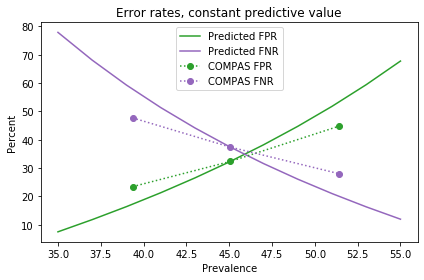

In [37]:
plot_cpv_model(pred_er)

actual_er['fpr'].plot(marker='o', linestyle='dotted', color='C2',
                      label='COMPAS FPR')

actual_er['fnr'].plot(marker='o', linestyle='dotted', color='C4',
                      label='COMPAS FNR')

plt.legend();

For the higher-prevalence group:

* The actual false positive rate is lower that what we would expect if the test had the same predictive value for all groups.

* The actual false negative rate is higher than expected.

For the lower-prevalence group:

* The actual false positive rate is higher than what we would expect if the test had the same predictive value for all groups.

* The actual false negative rate is lower than expected.

Relative to the CPV model, the COMPAS test is what I'll call "tempered", that is, less sensitive to variation in prevalence between groups.

## Constant error rate model

In the previous section we held predictive value constant and computed the effect on error rates.  In this section we'll go the other way: if we hold error rates constant for all groups, what effect does that have on predictive value?

The following function takes prevalence and error rates and returns a confusion matrix.



In [38]:
def constant_error_rates(fpr, fnr, prev):
    """Make a confusion matrix with given metrics.
    
    fpr: false positive rate (0 - 100)
    fnr: false negative rate (0 - 100)
    prev: prevalence (0 - 100)
    
    returns: confusion matrix
    """
    prev /= 100
    fpr /= 100
    fnr /= 100
    a = [[prev*(1 - fnr),  fpr*(1 - prev)],
         [fnr*prev,       (fpr - 1)*(prev - 1)]]
    
    return pd.DataFrame(a)

To test it, we can extract metrics for all defendants:

In [39]:
fpr, fnr = error_rates(matrix_all)
prev = prevalence(matrix_all)

And use them to compute the other metrics:

In [40]:
matrix = constant_error_rates(fpr, fnr, prev)
metrics_pred = compute_metrics(matrix)
metrics_pred

,Percent
,
FPR,32.349230
FNR,37.403876
PPV,61.350618
NPV,68.796510
Prevalence,45.065151


These "predicted metrics" are the same as the actual metrics, except for small errors due to floating-point approximation.

In [41]:
metrics_pred - metrics_all

,Percent
,
FPR,0.000000e+00
FNR,0.000000e+00
PPV,-7.105427e-15
NPV,1.421085e-14
Prevalence,0.000000e+00


Now we can see how predictive value depends on prevalence (with error rates held constant).

In [42]:
def run_cer_model(cp):
    """Run the constant error rate model.

    cp: DataFrame of COMPAS data

    returns: DataFrame with a row for each prevalence and
             a column for each metric (PPV, NPV)
    """
    matrix_all = make_matrix(cp)

    fpr, fnr = error_rates(matrix_all)
    prevalences = np.linspace(35, 65, 11)

    pred_pv = pd.DataFrame(columns=['ppv', 'npv'])

    for prev in prevalences:
        m = constant_error_rates(fpr, fnr, prev)
        pred_pv.loc[prev] = predictive_value(m)

    return pred_pv

In [43]:
pred_pv = run_cer_model(cp)
pred_pv

,ppv,npv
35.0,51.026704,77.058610
38.0,54.253815,74.689735
41.0,57.350053,72.243048
44.0,60.323222,69.714652
47.0,63.180516,67.100383
50.0,65.928580,64.395791
53.0,68.573560,61.596113
56.0,71.121148,58.696245
59.0,73.576628,55.690711
62.0,75.944906,52.573628


The following function plots results from the constant error rate (CER) model.

In [44]:
def plot_cer_model(pred_pv):
    """Plot error rates with constant predictive values.
    
    pred_er: DataFrame of predicted error rates
    """
    pred_pv['ppv'].plot(label='Predicted PPV', color='C0')
    pred_pv['npv'].plot(label='Predicted NPV', color='C1')
    decorate(xlabel='Prevalence', ylabel='Percent',
             title='Predictive value, constant error rates')

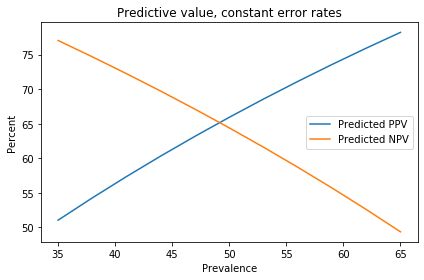

In [45]:
plot_cer_model(pred_pv)
plt.legend();

If we hold error rates constant and increase prevalence, PPV increases and NPV decreases.

For the COMPAS test, the effect is not as extreme.  The following loop computes the actual predictive values for the three groups.

In [46]:
actual_pv = pd.DataFrame(columns=['ppv', 'npv'])

for m in (matrix_white, matrix_all, matrix_black):
    prev = prevalence(m)
    actual_pv.loc[prev] = predictive_value(m)
    
actual_pv

,ppv,npv
39.364303,59.133489,71.187500
45.065151,61.350618,68.796510
51.433983,62.971481,65.045992


The following figure shows the actual predictive values compared to predictions from the constant error rate (CER) model.

The data points show error rates for white defendants (left), all defendants (middle), and black defendants (right).

The following figure shows the constant error rate model again, along with actual predictive values for white defendants (left), all defendants (middle), and black defendants (right).

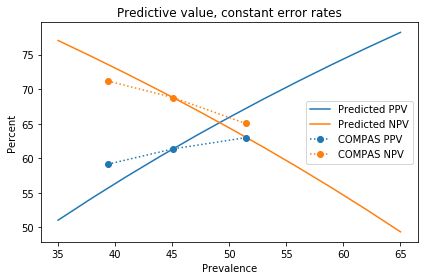

In [47]:
plot_cer_model(pred_pv)

actual_pv['ppv'].plot(marker='o', linestyle='dotted', color='C0',
                      label='COMPAS PPV')

actual_pv['npv'].plot(marker='o', linestyle='dotted', color='C1',
                      label='COMPAS NPV')

plt.legend();

Again, the test is less sensitive to differences in prevalence between groups than we would expect from the constant error rate model.



## Constant predictive value model

If two groups have difference prevalence, a binary classifier can have the same predictive values (PPV and NPV) for both groups, or the same error rates (FPR and FNR), but not both at the same time.

* If we are given predictive values, we can compute error rates for any prevalence.  I call this is the constant predictive value (CPV) model.

* If we are given error rates, we can compute predictive values for any prevalence.  I call this the constant error rate (CER) model.

In the previous sections, we saw that COMPAS does not follow either model with respect to black and white defendants.  Instead it seems to be "tempered", which means that when we compare groups with lower or higher prevalence:

* Error rates do not vary as much as the CPV model predicts.

* Predictive values do not vary as much as the CER model predicts.

The algorithms COMPAS uses are kept secret, so we can't tell whether this behavior is deliberate.

But we can get a clue by using the same analysis to compare other groups.

We'll compare the model with actual error rates for female and male defendants.

In [48]:
matrix_all = make_matrix(cp)

In [53]:
male = (cp['sex'] == 'Male')
matrix_male = make_matrix(cp[male])

In [54]:
female = (cp['sex'] == 'Female')
matrix_female = make_matrix(cp[female])

In [55]:
actual_er = pd.DataFrame(columns=['fpr', 'fnr'])

for m in (matrix_female, matrix_all, matrix_male):
    prev = prevalence(m)
    actual_er.loc[prev] = error_rates(m)
    
actual_er

,fpr,fnr
35.698925,32.107023,39.156627
45.065151,32.349230,37.403876
47.310534,32.420091,37.086814


The following figure compares predictions from the CPV model to actual error rates for female defendants (on the left), all defendants (in the middle), and male defendants (on the right).

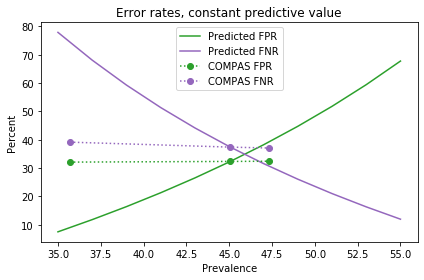

In [56]:
plot_cpv_model(pred_er)

actual_er['fpr'].plot(marker='o', linestyle='dotted', color='C2',
                      label='COMPAS FPR')

actual_er['fnr'].plot(marker='o', linestyle='dotted', color='C4',
                      label='COMPAS FNR')

plt.legend();

Although male and female defendants have very difference prevalences (rates of recidivism), their error rates are almost the same.

This is the "natural" behavior we should expect from a test that does not depend on sex.

If we look again at the definition of FPR and FNR, using this diagram from [Wikipedia](https://en.wikipedia.org/wiki/Confusion_matrix)

<img width=800, src='https://raw.githubusercontent.com/AllenDowney/ElementsOfDataScience/master/confusion_matrix2.png'>

We see that FNR depends only on people in the positive condition (people who will recidivate) and FPR depends only on people in the negative condition (people who will "survive" without being charged with another crime).

Neither error rate depends on how many people are in each condition, so if the test is sex blind, it should have the same error rates for both sexes, regardless of prevalence.

## Constant error rate model

The previous section shows the COMPAS has the same error rates for male and female defendants, even though they have substantially difference prevalences.

So we expected the test to have different predictive values for these groups.  To confirm that I'll compute the actual predictive values and compare them to the CER model.

The I'll use the CER model to compute PPV and NPV for a range of prevalences.

Here are the actual values for male and female defendants.

In [57]:
actual_pv = pd.DataFrame(columns=['ppv', 'npv'])

for m in (matrix_female, matrix_all, matrix_male):
    prev = prevalence(m)
    actual_pv.loc[prev] = predictive_value(m)
    
actual_pv

,ppv,npv
35.698925,51.269036,75.746269
45.065151,61.350618,68.796510
47.310534,63.536317,66.989977


The following figure compares the actual values to the CER model.

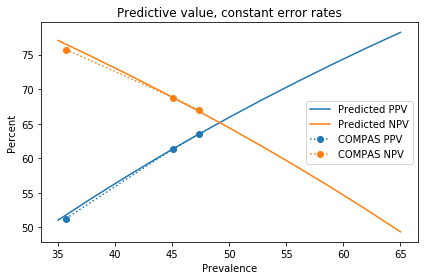

In [58]:
plot_cer_model(pred_pv)

actual_pv['ppv'].plot(marker='o', linestyle='dotted', color='C0',
                      label='COMPAS PPV')

actual_pv['npv'].plot(marker='o', linestyle='dotted', color='C1',
                      label='COMPAS NPV')

plt.legend();

## Summary

